<a href="https://colab.research.google.com/github/Tbrisley/Estimation-of-Multivariate-Discrete-Hawkes-Processes/blob/main/tongji_pytorch_mobilenetv2_unfreezed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
cudnn.benchmark = True

In [3]:
import zipfile
import os

zip_path = '/content/ROI.zip'
extract_dir = '/content/ROI'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted ROI.zip to", extract_dir)


Extracted ROI.zip to /content/ROI


In [17]:
import os
import shutil
import random
from pathlib import Path
from collections import defaultdict

# Settings
source_dir = '/content/ROI'
sessions = ['session1', 'session2']
train_dir = '/content/palmprint_training_set_tongji'
val_dir = '/content/palmprint_validation_set_tongji'
test_dir = '/content/palmprint_test_set_tongji'

# Clean output
for d in [train_dir, val_dir, test_dir]:
    shutil.rmtree(d, ignore_errors=True)
    os.makedirs(d, exist_ok=True)

# Group images by palm ID (0001, 0002, ..., 0600)
palm_groups = defaultdict(list)

for session in sessions:
    session_path = os.path.join(source_dir, session)
    for fname in sorted(os.listdir(session_path)):
        if not fname.endswith('.bmp'):
            continue
        index = int(Path(fname).stem)
        palm_id = (index - 1) // 10 + 1
        palm_name = f"{palm_id:04d}"  # '0001' to '0600'
        full_path = os.path.join(session_path, fname)
        palm_groups[palm_name].append(full_path)

# Split each palm's 20 images into train/val/test
def copy_images(image_list, target_dir, class_name):
    class_path = os.path.join(target_dir, class_name)
    os.makedirs(class_path, exist_ok=True)
    for path in image_list:
        shutil.copy(path, class_path)

for palm_name, image_paths in palm_groups.items():
    random.shuffle(image_paths)
    n = len(image_paths)
    n_train = int(n * 0.7)
    n_val = int(n * 0.2)
    n_test = n - n_train - n_val
    copy_images(image_paths[:n_train], train_dir, palm_name)
    copy_images(image_paths[n_train:n_train+n_val], val_dir, palm_name)
    copy_images(image_paths[n_train+n_val:], test_dir, palm_name)

print("✅ Done! Each split contains all users, with different palmprint images.")


✅ Done! Each split contains all users, with different palmprint images.


In [18]:
from torchvision import datasets, transforms
import torch
import os

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Correct data_dir
data_dir = '/content'

# Correct folder names used during splitting
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'palmprint_training_set_tongji'),
                                  data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'palmprint_validation_set_tongji'),
                                data_transforms['val'])
}

# DataLoaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                   shuffle=True, num_workers=2)
    for x in ['train', 'val']
}

# Dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


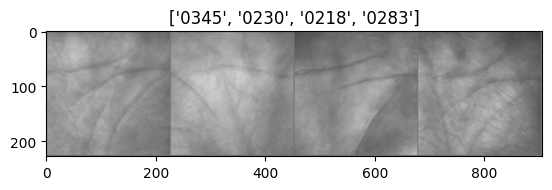

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=500):
    train_lss, val_lss, train_acc,val_acc = [], [], [], []
    since = time.time() #starting time

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #add to lists
            if phase == 'train':
              train_lss.append(float(epoch_loss))
              train_acc.append(float(epoch_acc))
            else:
              val_lss.append(float(epoch_loss))
              val_acc.append(float(epoch_acc))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_lss, val_lss, train_acc,val_acc

In [21]:
model_ft = models.mobilenet_v2(pretrained=True)
model_ft.classifier[1] = torch.nn.Linear(in_features=model_ft.classifier[1].in_features, out_features=len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00005)

# Decay LR by a factor of 0.1 every 100 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 94.9MB/s]


In [22]:
model_ft, train_lss, val_lss, train_acc,val_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=350)

Epoch 0/349
----------


KeyboardInterrupt: 

In [ ]:
torch.save(model_ft.state_dict(), 'MobileNetV2_tongji_unfreezed_04042022.pt')

In [ ]:
epochs = range(0,350)
plt.plot(epochs, train_acc, 'g', label='Training acc.')
plt.plot(epochs, val_acc, 'b', label='validation acc.')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc.png')
plt.show()

In [ ]:
epochs = range(0,350)
plt.plot(epochs, train_lss, 'g', label='Training loss')
plt.plot(epochs, val_lss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()